# PMF for Recommender Systems

- Reference https://towardsdatascience.com/pmf-for-recommender-systems-cbaf20f102f0

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

In [51]:
df = pd.read_csv('ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As part of the dataset, there is also another file that contains movie information, which includes the movie id, the title, the genre, among others. We can INNER JOIN the ratings and movies datasets to gain access to all data we will need for our analysis.

In [52]:
df_movies = pd.read_csv('movies.csv')
df_join = pd.merge(df_movies, df, how='inner', on='movieId')
df_join.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. Additionally, we will set S to 5 dimensions.

In [53]:
def ratings_matrix(df, train_size=0.8):
    users_list = {}
    movies_list = {}
   
    parameters = {}
    
    uniq_users = np.unique(df.userId.values)
    uniq_movies = np.unique(df.movieId.values)

    for i, user_id in enumerate(uniq_users):
        users_list[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movies_list[movie_id] = j
    
    num_users = len(uniq_users)
    num_movies = len(uniq_movies)
    
    R = np.zeros((num_users, num_movies))
    
    df_experiment = df.copy()
    train_set = df_experiment.sample(frac=train_size, random_state=0)
    test_set = df_experiment.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = users_list[row.userId]
        j = movies_list[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, num_users, num_movies, users_list, movies_list

Let's now call this function and retrieve all necessary parameters.

In [54]:
num_dims=10
R, train_set, test_set,  num_users, num_movies, users_list, movies_list = ratings_matrix(df_join, 0.8)


### Initialise our parameters


Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [55]:
parameters = {}

In [56]:
# def update_parameters():
#     U = parameters['U']
#     V = parameters['V']
#     lambda_U = parameters['lambda_U']
#     lambda_V = parameters['lambda_V']
    
#     for i in range(num_users):
#         V_j = V[:, R[i, :] > 0]
#         U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(num_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
#     for j in range(num_movies):
#         U_i = U[:, R[:, j] > 0]
#         V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(num_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
#     parameters['U'] = U
#     parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [57]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    
    r_ij = U[:, users_list[user_id]].T.reshape(1, -1) @ V[:, movies_list[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [58]:
def evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

For the purposes of scaling, we need the maximum and minimum rating values.

In [59]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [60]:
def log_a_posteriori():
    lambda_u = parameters['lambda_U']
    lambda_v = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_u * np.sum(np.dot(U, U.T)) + lambda_v * np.sum(np.dot(V, V.T)))

In [61]:
def train(n_epochs,lambda_u=0.3,lambda_v=0.3):
    
    log_aps = []
    rmse_train = []
    rmse_test = []
    #initialise parameters
    U = np.zeros((num_dims, num_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_v, (num_dims, num_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_u
    parameters['lambda_V'] = lambda_v
    
    
    update_max_min_ratings()
    rmse_train.append(evaluate(train_set))
    rmse_test.append(evaluate(test_set))
    
    for k in range(n_epochs):
        #update parameters
        for i in range(num_users):
            V_j = V[:, R[i, :] > 0]
            U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_u * np.identity(num_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
        for j in range(num_movies):
            U_i = U[:, R[:, j] > 0]
            V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_v * np.identity(num_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
        parameters['U'] = U
        parameters['V'] = V
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % 10 == 0:
            update_max_min_ratings()

            rmse_train.append(evaluate(train_set))
            rmse_test.append(evaluate(test_set))
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [62]:
log_ps, rmse_train, rmse_test = train(200)

Log p a-posteriori at iteration 10 : -21340.04590991172
Log p a-posteriori at iteration 20 : -17647.26119755933
Log p a-posteriori at iteration 30 : -15869.492327800977
Log p a-posteriori at iteration 40 : -14629.191205488514
Log p a-posteriori at iteration 50 : -13690.180242669601
Log p a-posteriori at iteration 60 : -12997.395692480704
Log p a-posteriori at iteration 70 : -12496.647469207832
Log p a-posteriori at iteration 80 : -12134.083083582029
Log p a-posteriori at iteration 90 : -11870.007170045903
Log p a-posteriori at iteration 100 : -11661.44039290928
Log p a-posteriori at iteration 110 : -11486.580407608988
Log p a-posteriori at iteration 120 : -11340.409400719522
Log p a-posteriori at iteration 130 : -11225.350249897889
Log p a-posteriori at iteration 140 : -11136.145028949879
Log p a-posteriori at iteration 150 : -11069.33792363025
Log p a-posteriori at iteration 160 : -11018.176954766575
Log p a-posteriori at iteration 170 : -10965.445553377354
Log p a-posteriori at itera

Now let's take a look at some graphs

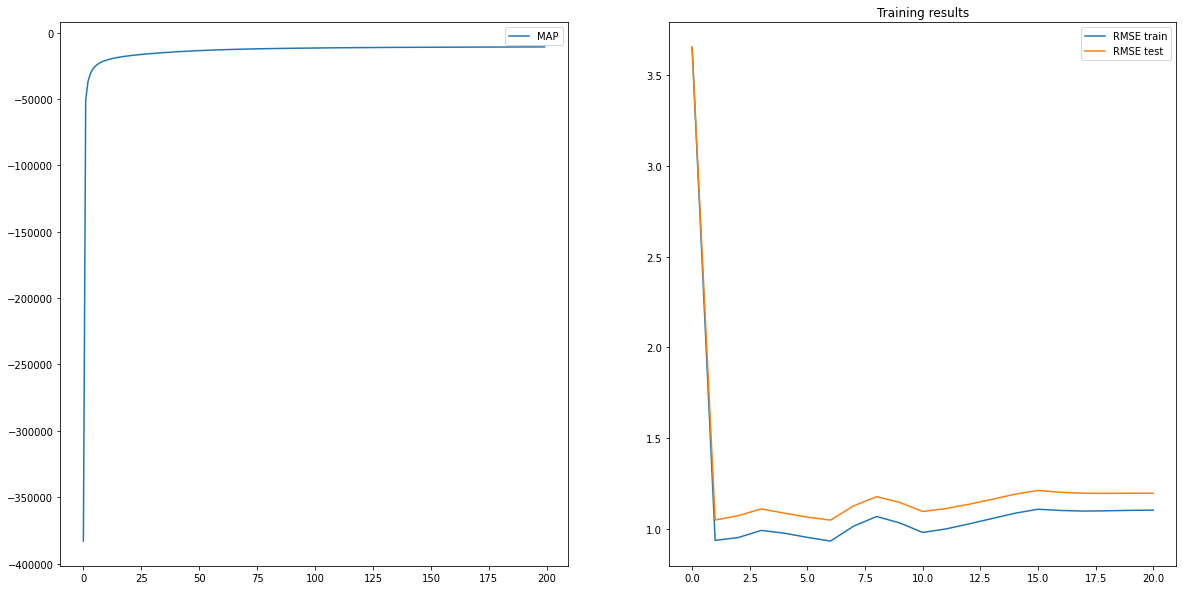

In [63]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [64]:
print('RMSE of training set:', evaluate(train_set))
print('RMSE of testing set:', evaluate(test_set))

RMSE of training set: 1.1015740960435176
RMSE of testing set: 1.1945840359248003


Now we will pick a user from the database and look at his/her preferences.

In [65]:
user_id = 10
df_join[df_join['userId'] == user_id].sort_values(by=['rating'], ascending=False).head(10)

,movieId,title,genres,userId,rating,timestamp
99259,140110,The Intern (2015),Comedy,10,5.0,1455356776
77147,8869,First Daughter (2004),Comedy|Romance,10,5.0,1455303064
94672,96079,Skyfall (2012),Action|Adventure|Thriller|IMAX,10,5.0,1455302172
93816,91529,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,10,5.0,1455302120
75192,7458,Troy (2004),Action|Adventure|Drama|War,10,5.0,1455356656
92100,81845,"King's Speech, The (2010)",Drama,10,5.0,1455302591
76341,8533,"Notebook, The (2004)",Drama|Romance,10,5.0,1455301847
91318,79091,Despicable Me (2010),Animation|Children|Comedy|Crime,10,5.0,1455306124
90172,71579,"Education, An (2009)",Drama|Romance,10,5.0,1455301869
80014,33794,Batman Begins (2005),Action|Crime|IMAX,10,5.0,1455302031


Let's look at the least preferred items.

In [66]:
df_join[df_join['userId'] == user_id].sort_values(by=['rating']).head(10)

,movieId,title,genres,userId,rating,timestamp
96729,109487,Interstellar (2014),Sci-Fi|IMAX,10,0.5,1455398092
96670,109374,"Grand Budapest Hotel, The (2014)",Comedy|Drama,10,0.5,1455302315
21988,1028,Mary Poppins (1964),Children|Comedy|Fantasy|Musical,10,0.5,1455306152
88624,64969,Yes Man (2008),Comedy,10,0.5,1455357607
49837,2959,Fight Club (1999),Action|Crime|Drama|Thriller,10,0.5,1455356582
94899,97024,Rust and Bone (De rouille et d'os) (2012),Drama|Romance,10,0.5,1455301892
45016,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,10,0.5,1455356378
89898,70293,Julie & Julia (2009),Comedy|Drama|Romance,10,0.5,1455398141
47684,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery,10,0.5,1455356388
7865,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,10,1.0,1455303387


Let's now look at the most likely preferences of the selected user.

In [67]:
predictions = np.zeros((num_movies, 1))
movies_list_items = np.array(list(movies_list.items()))
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])

for i, movie in enumerate(movies_list_items):
    predictions[i] = predict(user_id, movie[0])
    
indices = np.argsort(-predictions, axis=0)

for j in range(10):
    movie_id = int(movies_list_items[np.where(movies_list_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,10,880,"Island of Dr. Moreau, The (1996)",Sci-Fi|Thriller,3.977719
1,10,102903,Now You See Me (2013),Crime|Mystery|Thriller,3.952081
2,10,543,So I Married an Axe Murderer (1993),Comedy|Romance|Thriller,3.929483
3,10,108190,Divergent (2014),Adventure|Romance|Sci-Fi|IMAX,3.842856
4,10,1711,Midnight in the Garden of Good and Evil (1997),Crime|Drama|Mystery,3.834595
5,10,273,Mary Shelley's Frankenstein (Frankenstein) (1994),Drama|Horror|Sci-Fi,3.796053
6,10,3440,Teenage Mutant Ninja Turtles III (1993),Action|Adventure|Children|Comedy|Fantasy,3.741631
7,10,81564,Megamind (2010),Action|Animation|Children|Comedy|Sci-Fi|IMAX,3.651779
8,10,4002,"Planes, Trains & Automobiles (1987)",Comedy,3.648877
9,10,218,Boys on the Side (1995),Comedy|Drama,3.648483


Now the predictions for least preferred items.

In [68]:
df_result = pd.DataFrame(columns=['UserID', 'MovieID', 'Movie', 'Genres', 'Prediction'])
indices = np.argsort(predictions, axis=0)

for j in range(10):
    movie_id = int(movies_list_items[np.where(movies_list_items[:, 1] == indices[j])][0][0])
    df_row = pd.DataFrame({
        'UserID': user_id,
        'MovieID': movie_id,
        'Movie': df_movies[df_movies['movieId'] == movie_id].iloc[0]['title'],
        'Genres': df_movies[df_movies['movieId'] == movie_id].iloc[0]['genres'],
        'Prediction': predictions[indices[j]][0][0]
    }, index=[j])
    df_result = df_result.append(df_row, sort=False)
    
df_result

,UserID,MovieID,Movie,Genres,Prediction
0,10,4255,Freddy Got Fingered (2001),Comedy,0.857602
1,10,59900,You Don't Mess with the Zohan (2008),Comedy,1.116384
2,10,8638,Before Sunset (2004),Drama|Romance,1.125589
3,10,48322,Jackass Number Two (2006),Comedy|Documentary,1.219889
4,10,3608,Pee-wee's Big Adventure (1985),Adventure|Comedy,1.334020
5,10,3917,Hellraiser (1987),Horror,1.369610
6,10,87529,Your Highness (2011),Action|Adventure|Comedy|Fantasy,1.436848
7,10,104879,Prisoners (2013),Drama|Mystery|Thriller,1.451032
8,10,3824,Autumn in New York (2000),Drama|Romance,1.468157
9,10,59022,Harold & Kumar Escape from Guantanamo Bay (2008),Adventure|Comedy,1.503563


I hope you enjoyed this exercise. Something you can also try on your own is to implement gradient descent instead of MAP-estimation like I did here. Let me know about any comments you may have.